In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import numpy as np
import tensorflow as tf

tf.compat.v1.enable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
train_final = pd.read_csv('../data/train_final.csv')
valid_final = pd.read_csv('../data/valid_final.csv')

print((train_final.shape, valid_final.shape))

((1845, 103), (279, 104))


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
obsIDs = valid_final.loc[:, "obsId"]

In [6]:
train_final.columns

Index(['Unnamed: 0', 'isFinal_t_0', 'MinutesSincePreviousCommit_t_0',
       'NumberOfFilesAdded_t_0', 'NumberOfFilesAddedNet_t_0',
       'NumberOfLinesAddedByAddedFiles_t_0',
       'NumberOfLinesAddedByAddedFilesNet_t_0', 'NumberOfFilesDeleted_t_0',
       'NumberOfFilesDeletedNet_t_0', 'NumberOfLinesDeletedByDeletedFiles_t_0',
       ...
       'd_NumberOfLinesAddedByRenamedFiles_t_1',
       'd_NumberOfLinesAddedByRenamedFilesNet_t_1',
       'd_NumberOfLinesDeletedByRenamedFiles_t_1',
       'd_NumberOfLinesDeletedByRenamedFilesNet_t_1', 'd_Density_t_1',
       'd_AffectedFilesRatioNet_t_1', 'est_t1', 'est_t0', 'y_t1', 'y_t0'],
      dtype='object', length=103)

In [7]:
allNames = list(train_final.columns[1:len(train_final.columns)])
#allNames = allNames[49:len(allNames)]
#useIdx = np.r_[0:49, 109:len(allNames)]
#allNames = [allNames[i] for i in useIdx]
print(allNames)

['isFinal_t_0', 'MinutesSincePreviousCommit_t_0', 'NumberOfFilesAdded_t_0', 'NumberOfFilesAddedNet_t_0', 'NumberOfLinesAddedByAddedFiles_t_0', 'NumberOfLinesAddedByAddedFilesNet_t_0', 'NumberOfFilesDeleted_t_0', 'NumberOfFilesDeletedNet_t_0', 'NumberOfLinesDeletedByDeletedFiles_t_0', 'NumberOfLinesDeletedByDeletedFilesNet_t_0', 'NumberOfFilesModified_t_0', 'NumberOfFilesModifiedNet_t_0', 'NumberOfFilesRenamed_t_0', 'NumberOfFilesRenamedNet_t_0', 'NumberOfLinesAddedByModifiedFiles_t_0', 'NumberOfLinesAddedByModifiedFilesNet_t_0', 'NumberOfLinesDeletedByModifiedFiles_t_0', 'NumberOfLinesDeletedByModifiedFilesNet_t_0', 'NumberOfLinesAddedByRenamedFiles_t_0', 'NumberOfLinesAddedByRenamedFilesNet_t_0', 'NumberOfLinesDeletedByRenamedFiles_t_0', 'NumberOfLinesDeletedByRenamedFilesNet_t_0', 'Density_t_0', 'AffectedFilesRatioNet_t_0', 'isInitial_t_1', 'precByMerge_t_1', 'MinutesSincePreviousCommit_t_1', 'NumberOfFilesAdded_t_1', 'NumberOfFilesAddedNet_t_1', 'NumberOfLinesAddedByAddedFiles_t_1',

In [8]:
# we have 2 Y-labels!
namesX = allNames[0:(len(allNames)-2)]
namesY = allNames[(len(allNames)-2):len(allNames)]

In [9]:
train_X = train_final.loc[:, namesX]
train_Y = train_final.loc[:, namesY]
valid_X = valid_final.loc[:, namesX]
valid_Y = valid_final.loc[:, namesY]

In [10]:
from sklearn.preprocessing import StandardScaler

# We only need a scaler on X. Also, we only fit the scaler
# on the training-data, pretending we do not yet know about
# the validation data.
scaler_X = StandardScaler().fit(train_X)

In [11]:
train_data = scaler_X.transform(train_X)
valid_data = scaler_X.transform(valid_X)

In [34]:
train_targets = train_Y.to_numpy()
valid_targets = valid_Y.to_numpy()
print((train_targets.shape, valid_targets.shape))

((1845, 2), (279, 2))


In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15440105810225886265
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9210949796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1125333543825428740
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:13:00.0, compute capability: 6.1"
]


In [14]:
from keras import models, layers, initializers, losses, metrics, optimizers, callbacks
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x, beta = 2):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

In [47]:
model = models.Sequential()

#model.add(layers.Dense(units=512,  activation='swish', kernel_initializer='glorot_uniform'))
model.add(layers.Dense(units=32,   activation='swish', kernel_initializer='glorot_uniform'))
#model.add(layers.Dropout(1/3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=8,   activation='swish', kernel_initializer='glorot_uniform'))
model.add(layers.Dense(units=train_Y.shape[1], activation='sigmoid', kernel_initializer='glorot_uniform'))

opt = optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt, loss='mse', metrics=[
    metrics.CategoricalAccuracy()
])

In [48]:
tf.random.set_seed(1337)

es = callbacks.EarlyStopping(
    monitor='loss', mode='min', min_delta=1e-3, verbose=1,
    patience=15, restore_best_weights=True)

hist = model.fit(
    x=train_data, y=train_targets, batch_size=32, epochs=10000, verbose=1,
    callbacks=[es], validation_data=(valid_data, valid_targets))

Train on 1845 samples, validate on 279 samples
Epoch 1/10000
1845/1845 [==============================] - 1s 438us/step - loss: 0.3236 - categorical_accuracy: 0.6309 - val_loss: 0.3366 - val_categorical_accuracy: 0.6201
Epoch 2/10000
1845/1845 [==============================] - 0s 208us/step - loss: 0.3118 - categorical_accuracy: 0.6222 - val_loss: 0.3306 - val_categorical_accuracy: 0.6129
Epoch 3/10000
1845/1845 [==============================] - 0s 213us/step - loss: 0.3032 - categorical_accuracy: 0.6358 - val_loss: 0.3271 - val_categorical_accuracy: 0.6022
Epoch 4/10000
1845/1845 [==============================] - 0s 215us/step - loss: 0.2944 - categorical_accuracy: 0.6390 - val_loss: 0.3209 - val_categorical_accuracy: 0.6093
Epoch 5/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.2875 - categorical_accuracy: 0.6298 - val_loss: 0.3183 - val_categorical_accuracy: 0.6022
Epoch 6/10000
1845/1845 [==============================] - 0s 212us/step - loss: 0.2826 

Epoch 48/10000
1845/1845 [==============================] - 0s 210us/step - loss: 0.2106 - categorical_accuracy: 0.6472 - val_loss: 0.2463 - val_categorical_accuracy: 0.6201
Epoch 49/10000
1845/1845 [==============================] - 0s 217us/step - loss: 0.2105 - categorical_accuracy: 0.6526 - val_loss: 0.2462 - val_categorical_accuracy: 0.6272
Epoch 50/10000
1845/1845 [==============================] - 0s 215us/step - loss: 0.2110 - categorical_accuracy: 0.6499 - val_loss: 0.2455 - val_categorical_accuracy: 0.6129
Epoch 51/10000
1845/1845 [==============================] - 0s 217us/step - loss: 0.2084 - categorical_accuracy: 0.6385 - val_loss: 0.2447 - val_categorical_accuracy: 0.6237
Epoch 52/10000
1845/1845 [==============================] - 0s 215us/step - loss: 0.2079 - categorical_accuracy: 0.6542 - val_loss: 0.2438 - val_categorical_accuracy: 0.6308
Epoch 53/10000
1845/1845 [==============================] - 0s 215us/step - loss: 0.2076 - categorical_accuracy: 0.6575 - val_loss

1845/1845 [==============================] - 0s 216us/step - loss: 0.1867 - categorical_accuracy: 0.6428 - val_loss: 0.2249 - val_categorical_accuracy: 0.6272
Epoch 96/10000
1845/1845 [==============================] - 0s 220us/step - loss: 0.1856 - categorical_accuracy: 0.6466 - val_loss: 0.2245 - val_categorical_accuracy: 0.6272
Epoch 97/10000
1845/1845 [==============================] - 0s 214us/step - loss: 0.1843 - categorical_accuracy: 0.6493 - val_loss: 0.2235 - val_categorical_accuracy: 0.6344
Epoch 98/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.1844 - categorical_accuracy: 0.6537 - val_loss: 0.2238 - val_categorical_accuracy: 0.6380
Epoch 99/10000
1845/1845 [==============================] - 0s 218us/step - loss: 0.1844 - categorical_accuracy: 0.6482 - val_loss: 0.2242 - val_categorical_accuracy: 0.6344
Epoch 100/10000
1845/1845 [==============================] - 0s 230us/step - loss: 0.1844 - categorical_accuracy: 0.6509 - val_loss: 0.2236 - val

Epoch 142/10000
1845/1845 [==============================] - 0s 207us/step - loss: 0.1692 - categorical_accuracy: 0.6694 - val_loss: 0.2238 - val_categorical_accuracy: 0.6165
Epoch 143/10000
1845/1845 [==============================] - 0s 217us/step - loss: 0.1678 - categorical_accuracy: 0.6688 - val_loss: 0.2225 - val_categorical_accuracy: 0.6093
Epoch 144/10000
1845/1845 [==============================] - 0s 210us/step - loss: 0.1685 - categorical_accuracy: 0.6602 - val_loss: 0.2220 - val_categorical_accuracy: 0.6093
Epoch 145/10000
1845/1845 [==============================] - 0s 209us/step - loss: 0.1682 - categorical_accuracy: 0.6661 - val_loss: 0.2205 - val_categorical_accuracy: 0.6129
Epoch 146/10000
1845/1845 [==============================] - 0s 218us/step - loss: 0.1663 - categorical_accuracy: 0.6596 - val_loss: 0.2201 - val_categorical_accuracy: 0.6129
Epoch 147/10000
1845/1845 [==============================] - 0s 210us/step - loss: 0.1677 - categorical_accuracy: 0.6607 - va

1845/1845 [==============================] - 0s 213us/step - loss: 0.1560 - categorical_accuracy: 0.6726 - val_loss: 0.2314 - val_categorical_accuracy: 0.6237
Epoch 189/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.1556 - categorical_accuracy: 0.6705 - val_loss: 0.2311 - val_categorical_accuracy: 0.6201
Epoch 190/10000
1845/1845 [==============================] - 0s 214us/step - loss: 0.1564 - categorical_accuracy: 0.6596 - val_loss: 0.2312 - val_categorical_accuracy: 0.6165
Epoch 191/10000
1845/1845 [==============================] - 0s 216us/step - loss: 0.1555 - categorical_accuracy: 0.6726 - val_loss: 0.2312 - val_categorical_accuracy: 0.6237
Epoch 192/10000
1845/1845 [==============================] - 0s 212us/step - loss: 0.1553 - categorical_accuracy: 0.6688 - val_loss: 0.2317 - val_categorical_accuracy: 0.6272
Epoch 193/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.1557 - categorical_accuracy: 0.6737 - val_loss: 0.2320 -

Epoch 235/10000
1845/1845 [==============================] - 0s 221us/step - loss: 0.1463 - categorical_accuracy: 0.6715 - val_loss: 0.2314 - val_categorical_accuracy: 0.6380
Epoch 236/10000
1845/1845 [==============================] - 0s 216us/step - loss: 0.1471 - categorical_accuracy: 0.6797 - val_loss: 0.2316 - val_categorical_accuracy: 0.6380
Epoch 237/10000
1845/1845 [==============================] - 0s 222us/step - loss: 0.1446 - categorical_accuracy: 0.6862 - val_loss: 0.2318 - val_categorical_accuracy: 0.6380
Epoch 238/10000
1845/1845 [==============================] - 0s 210us/step - loss: 0.1452 - categorical_accuracy: 0.6840 - val_loss: 0.2322 - val_categorical_accuracy: 0.6380
Epoch 239/10000
1845/1845 [==============================] - 0s 215us/step - loss: 0.1456 - categorical_accuracy: 0.6867 - val_loss: 0.2322 - val_categorical_accuracy: 0.6380
Epoch 240/10000
1845/1845 [==============================] - 0s 217us/step - loss: 0.1464 - categorical_accuracy: 0.6780 - va

Epoch 282/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.1370 - categorical_accuracy: 0.6916 - val_loss: 0.2319 - val_categorical_accuracy: 0.6523
Epoch 283/10000
1845/1845 [==============================] - 0s 216us/step - loss: 0.1370 - categorical_accuracy: 0.6894 - val_loss: 0.2320 - val_categorical_accuracy: 0.6380
Epoch 284/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.1366 - categorical_accuracy: 0.6916 - val_loss: 0.2334 - val_categorical_accuracy: 0.6487
Epoch 285/10000
1845/1845 [==============================] - 0s 223us/step - loss: 0.1381 - categorical_accuracy: 0.6764 - val_loss: 0.2335 - val_categorical_accuracy: 0.6452
Epoch 286/10000
1845/1845 [==============================] - 0s 211us/step - loss: 0.1378 - categorical_accuracy: 0.6786 - val_loss: 0.2328 - val_categorical_accuracy: 0.6452
Epoch 287/10000
1845/1845 [==============================] - 0s 209us/step - loss: 0.1380 - categorical_accuracy: 0.6764 - va

Epoch 329/10000
1845/1845 [==============================] - 0s 221us/step - loss: 0.1309 - categorical_accuracy: 0.6927 - val_loss: 0.2330 - val_categorical_accuracy: 0.6667
Restoring model weights from the end of the best epoch
Epoch 00329: early stopping


In [49]:
import matplotlib.pyplot as plt

print(hist.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


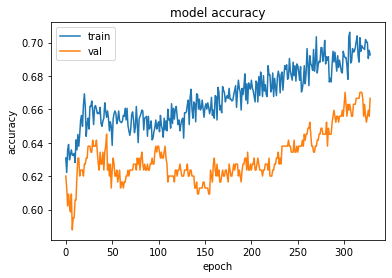

In [50]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

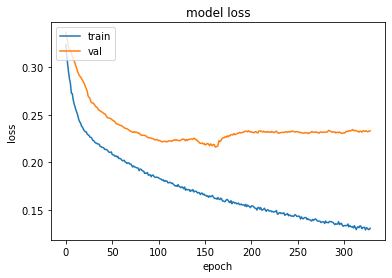

In [55]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
valid_data.shape

(279, 100)

In [57]:
valid_targets.shape

(279, 2)

In [58]:
pred = model.predict(x=valid_data)
np.round(pred)

array([[0., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.

In [30]:
testtest = np.hstack((obsIDs.to_numpy().reshape((len(obsIDs),1)), valid_final.loc[:, ["est_t1", "est_t0"]].to_numpy(), valid_targets, pred))

In [31]:
testtest.shape

(279, 7)

In [540]:
np.savetxt('test.csv', testtest, delimiter=",")

In [148]:
np.savetxt('targ.csv', valid_targets)

In [563]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_data, train_targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [564]:
clf.predict(valid_data)

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int64)